# Import packages

In [30]:
## Generic packages that are on your operating system
import glob
import os
import time

## Additional required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## Important scikit-learn packages for fitting logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## Required definitions and constants

In [3]:
files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))
            
    for y_min, y_max in zip(box_down,box_up):    
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

# Load in data

In [160]:
files = glob.glob('datasets/cGAN_50*_Nairobi.zarr')
ds_cGAN_50 = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN_50.append(ds_temp) 
ds_cGAN_50 = xr.concat(ds_cGAN_50, 'time').sortby('time')

files = glob.glob('datasets/cGAN_2*_Nairobi.zarr')
ds_cGAN = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN.append(ds_temp) 
ds_cGAN = xr.concat(ds_cGAN, 'time').sortby('time')

files = glob.glob('datasets/IFS*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time')

meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')


/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_37101/3265667171.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_37101/3265667171.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This w

## Load observational point data

In [175]:
def parser(vals):
    vals_temp = np.zeros_like(vals.flatten())
    for i, val in enumerate(vals.flatten()):
        if type(val) is str:
            try:
                vals_temp[i] = val.replace('..','.').replace(" ","").astype(np.float64)
            except:
                vals_temp[i] = 0
            
        else:
            vals_temp[i] = val
    
    return vals_temp.astype(np.float64)
    
file_path='SEWAA-data.xlsx'
sheets = pd.ExcelFile(file_path).sheet_names

meta = []
ds = []
for sheet in sheets[:-1]:

    df_meta = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet)
    columns = df_meta.columns
    region = np.unique(df_meta['Station_Name'])
    region = [region[0].split(" ")[0]]
    try:
        lat = np.unique(df_meta['lat'])
        lon = np.unique(df_meta['lon'])
    except:
        lat = np.unique(df_meta['Lat'])
        lon = np.unique(df_meta['Lon'])
    meta.append(xr.DataArray(data=np.hstack((lon,lat))[None,:],
                            dims = ['region','ID'],
                            coords = {'region':region,
                                     'ID':['lon','lat']}))
    year_idx = np.squeeze(np.argwhere(columns=='Year'))
    use_cols = np.arange(33)+year_idx
    df = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet,
                       index_col=[0,1],usecols=use_cols)
    data = []
    times = []
    for year,month in df.index.values:
        if month!=12:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year}-{month+1:02}-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))
        else:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year+1}-01-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))

        no_of_days = len(times[-1])

        data.append(parser(df.loc[[(year,month)]].values).reshape(-1,1)[:no_of_days])


    times = np.hstack((times))
    data = np.vstack((data))

    ds.append(xr.DataArray(data=data,
                           dims = ['time','region'],
                           coords = {
                               'time':times,
                               'region':region,
                           }))

meta = xr.concat(meta,'region').to_dataset('region')
ds = xr.concat(ds,'region').to_dataset('region')


In [172]:
ds

<xarray.Dataset> Size: 140kB
Dimensions:    (time: 2496)
Coordinates:
  * time       (time) datetime64[ns] 20kB 2018-01-01 2018-01-02 ... 2024-10-31
Data variables:
    KABETE     (time) float64 20kB 1.0 0.0 20.0 5.0 0.2 ... nan nan nan nan nan
    EASTLEIGH  (time) float64 20kB 0.0 1.4 4.1 0.6 0.0 ... 0.0 0.0 0.0 0.0 0.0
    J.K.I.A.   (time) float64 20kB 0.0 7.5 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    DAGORETTI  (time) float64 20kB 0.0 0.0 9.1 2.8 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NGONG      (time) float64 20kB 0.0 26.9 0.0 2.1 4.3 ... 0.0 0.0 0.0 0.0 0.0
    WILSON     (time) float64 20kB 0.0 0.0 9.9 0.9 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [178]:
## Make train dataset
train_years = [2018,2019,2020]
train_data_x = {}

train_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(train_years))
train_data_x['cGAN_50'] = ds_cGAN_50.sel(time=ds_cGAN_50.time.dt.year.isin(train_years))
train_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(train_years))

train_valid_times = np.intersect1d(train_data_x['cGAN'].time.values + np.timedelta64(1,'D'),
                                   ds.time.values)
train_data_x['cGAN'] = train_data_x['cGAN'].sel({'time':train_valid_times - np.timedelta64(1,'D')})
train_data_x['cGAN_50'] = train_data_x['cGAN_50'].sel({'time':train_valid_times - np.timedelta64(1,'D')})
train_data_x['IFS'] = train_data_x['IFS'].sel({'time':train_valid_times - np.timedelta64(1,'D')})

train_data_y = ds.sel({'time':train_valid_times})

## Make validation dataset
val_years = [2021]
val_data_x = {}

val_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(val_years))
val_data_x['cGAN_50'] = ds_cGAN.sel(time=ds_cGAN_50.time.dt.year.isin(val_years))
val_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(val_years))

val_valid_times = np.intersect1d(val_data_x['cGAN'].time.values + np.timedelta64(1,'D'),
                                   ds.time.values)
val_data_x['cGAN'] = val_data_x['cGAN'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['cGAN_50'] = val_data_x['cGAN_50'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['IFS'] = val_data_x['IFS'].sel({'time':val_valid_times - np.timedelta64(1,'D')})

val_data_y = ds.sel({'time':val_valid_times})

val_data_y

<xarray.Dataset> Size: 20kB
Dimensions:    (time: 352)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2021-01-02 2021-01-03 ... 2021-12-30
Data variables:
    KABETE     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 2.1 0.0 0.0 0.0 0.0
    EASTLEIGH  (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.1 0.0 0.3 0.0 0.0
    J.K.I.A.   (time) float64 3kB 0.4 0.0 0.0 0.0 0.0 ... 0.6 0.0 1.2 0.0 0.0
    DAGORETTI  (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NGONG      (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 1.7 0.0 0.0 0.0 0.0
    WILSON     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.3 0.7 0.0 0.0 0.0

# Fit model for region

In [45]:
model = 'cGAN'
region = 'KABETE'
n_knots = 5
degree = 1
polyfeatures = 1

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)

train_data_y_region = train_data_y[region].values
train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values

if train_data_x_region.shape[1]==1000:
    train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T

# Manually make pipeline in future can use from sklearn.pipeline import make_pipeline
spline = SplineTransformer(n_knots=n_knots, degree=degree, knots='uniform',extrapolation='linear').fit(train_data_x_region)
polyfeatures = PolynomialFeatures(polyfeatures, interaction_only=True).fit(spline.transform(train_data_x_region))

transformed_x_region = polyfeatures.transform(spline.transform(train_data_x_region))

logreg = LogisticRegression(penalty='elasticnet',
                            l1_ratio=0.8,solver='saga',max_iter=100_000).fit(transformed_x_region,
                                                                             np.searchsorted([5,20,40],train_data_y_region))


In [52]:
## Define the bin for which we plot the calibraiton curve (i.e., 0, 1, 2, 3 for <5, 5-20, 20-50 and >50 respectively)
bin_to_plot = 2

## We get the true probabilities of occurrence for this bin as is in our y-vales
## we use np.where for this, see documentation here: https://numpy.org/doc/stable/reference/generated/numpy.where.html
actual_probabilities = np.where(np.searchsorted([5,20,40],train_data_y_region)==bin_to_plot,1,0)

## Now we get the predicted probabilities from the fitted models using the function predict_proba and
## The output of predict proba is of the shape (n_samples, n_bins) and we select our bin (i.e., [:,bin_to_plot] of interest
pred_probabilities = logreg.predict_proba(transformed_x_region)[:,bin_to_plot]#polyfeatures.transform(spline.transform(train_data_x_region))




Text(0, 0.5, 'Fraction of Positives [-]')

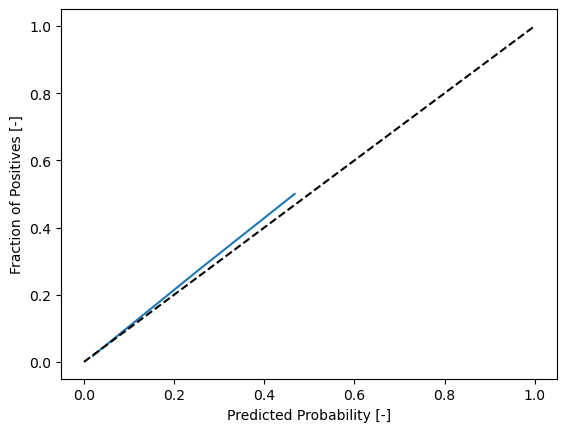

In [53]:
fraction_of_positives, predicted_prob = calibration_curve(actual_probabilities, pred_probabilities, n_bins=5)

plt.plot(predicted_prob, fraction_of_positives)
plt.plot([0,1],[0,1], color="black", linestyle="dashed")

plt.xlabel("Predicted Probability [-]")
plt.ylabel("Fraction of Positives [-]")


# Looping through regions for GridSearchCV

In [ ]:
from tqdm import tqdm
thresholds = [5,20,40]
gridsearch_results = {}

cross_validation = 7
param_grid = {'spline__n_knots':[5,7,10,15],'logreg__l1_ratio':np.arange(0.6,1,0.1)}

for model in ['IFS','cGAN','cGAN_50']:
    gridsearch_results[model] = {}
    print('Fitting for model:', model)        
    for region in ['KABETE','EASTLEIGH','J.K.I.A.','WILSON','DAGORETTI']:#
        model_pipeline = Pipeline(steps=[('spline', SplineTransformer(n_knots=5, degree=1, knots='uniform',extrapolation='linear')),
                                ('polyfeat', PolynomialFeatures(1, interaction_only=True)),
                                ('logreg', LogisticRegression(penalty='elasticnet',
                            l1_ratio=0.6,solver='saga',max_iter=100_000))])
        gridsearch = GridSearchCV(model_pipeline, param_grid, cv=cross_validation, n_jobs=4, scoring='neg_log_loss',verbose=False)
        idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
        
        train_data_y_region = train_data_y[region].values.astype(np.float64)
        train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values
        
        if train_data_x_region.shape[1]==1000:
            train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T
    
        gridsearch_results[model][region] = gridsearch.fit(train_data_x_region, np.searchsorted(thresholds,train_data_y_region))

    

    

Fitting for model: IFS
Fitting for model: cGAN


In [151]:
model = "cGAN"
region = "KABETE"

gridsearch_results[model][region].best_params_

{'logreg__l1_ratio': np.float64(0.8999999999999999), 'spline__n_knots': 10}

Text(0, 0.5, 'Fraction of Positives [-]')

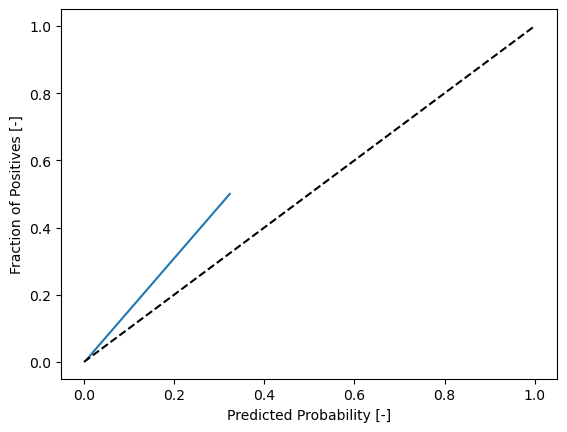

In [145]:
model = 'IFS'
region = 'KABETE'
thresholds = [5,20,40]

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
    
train_data_y_region = train_data_y[region].values
train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values

if train_data_x_region.shape[1]==1000:
    train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T


logreg = Pipeline(steps=[('spline', SplineTransformer(n_knots=gridsearch_results[model][region].best_params_['spline__n_knots'], 
                                                      degree=1, knots='uniform',extrapolation='linear')),
                                ('polyfeat', PolynomialFeatures(1, interaction_only=True)),
                                ('logreg', LogisticRegression(penalty='elasticnet',
                            l1_ratio=gridsearch_results[model][region].best_params_['logreg__l1_ratio'],solver='saga',max_iter=100_000))])

logreg.fit(train_data_x_region, np.searchsorted(thresholds,train_data_y_region))

val_data_y_region = val_data_y[region].values
val_data_x_region = val_data_x[model].isel({'latlon':idx_region}).Nairobi.values

if val_data_x_region.shape[1]==1000:
    val_data_x_region = np.percentile(val_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T



## Define the bin for which we plot the calibraiton curve (i.e., 0, 1, 2, 3 for <5, 5-20, 20-50 and >50 respectively)
bin_to_plot = 3

## We get the true probabilities of occurrence for this bin as is in our y-vales
## we use np.where for this, see documentation here: https://numpy.org/doc/stable/reference/generated/numpy.where.html
actual_probabilities = np.where(np.searchsorted([5,20,40],val_data_y_region)==bin_to_plot,1,0)

## Now we get the predicted probabilities from the fitted models using the function predict_proba and
## The output of predict proba is of the shape (n_samples, n_bins) and we select our bin (i.e., [:,bin_to_plot] of interest
pred_probabilities = logreg.predict_proba(val_data_x_region)[:,bin_to_plot]#polyfeatures.transform(spline.transform(train_data_x_region))

fraction_of_positives, predicted_prob = calibration_curve(actual_probabilities, pred_probabilities, n_bins=5)

plt.plot(predicted_prob, fraction_of_positives)
plt.plot([0,1],[0,1], color="black", linestyle="dashed")

plt.xlabel("Predicted Probability [-]")
plt.ylabel("Fraction of Positives [-]")

# Save the models

In [149]:
import joblib

if not os.path.exists('models/'):
    os.makedirs('models/')

for model in ['IFS','cGAN','cGAN_50']:
    for region in ['KABETE','EASTLEIGH','J.K.I.A.','WILSON','DAGORETTI']:
        idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
            
        train_data_y_region = train_data_y[region].values
        train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values
        
        if train_data_x_region.shape[1]==1000:
            train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T
        
        
        logreg = Pipeline(steps=[('spline', SplineTransformer(n_knots=gridsearch_results[model][region].best_params_['spline__n_knots'], 
                                                              degree=1, knots='uniform',extrapolation='linear')),
                                        ('polyfeat', PolynomialFeatures(1, interaction_only=True)),
                                        ('logreg', LogisticRegression(penalty='elasticnet',
                                    l1_ratio=gridsearch_results[model][region].best_params_['logreg__l1_ratio'],solver='saga',max_iter=100_000))])
        
        logreg.fit(train_data_x_region, np.searchsorted(thresholds,train_data_y_region))

        joblib.dump(logreg,f'models/{model}_{region}_1-day_fcst.pkl')
        
